## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [ ]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=VrrO3Zoj0aY0Z3Cq7fR_PcoCYqEV1Y3c3CDg2okyeog&tc=6vqRAdBIZfcFrKzUTU0ar7HRX4_1tqSIu86XxocnciM&cc=cy3ZLNlG6hYmr0UQxqQi8CcbgFHKuth66pkpmGM59M8

The authorization workflow will generate a code, which you should paste in the box below.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Testing and Examples


## Test the API

Test the API by printing the elevation of Mount Everest.

In [ ]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


## Map visualization

`ee.Image` objects can be displayed to notebook output cells. The following two
examples demonstrate displaying a static image and an interactive map.


### Static image

The `IPython.display` module contains the `Image` function, which can display
the results of a URL representing an image generated from a call to the Earth
Engine `getThumbUrl` function. The following cell will display a thumbnail
of the global elevation model.

In [ ]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbURL({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

### Interactive map

The [`folium`](https://python-visualization.github.io/folium/)
library can be used to display `ee.Image` objects on an interactive
[Leaflet](https://leafletjs.com/) map. Folium has no default
method for handling tiles from Earth Engine, so one must be defined
and added to the `folium.Map` module before use.

The following cell provides an example of adding a method for handing Earth Engine
tiles and using it to display an elevation model to a Leaflet map.

In [ ]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

## Chart visualization

Some Earth Engine functions produce tabular data that can be plotted by
data visualization packages such as `matplotlib`. The following example
demonstrates the display of tabular data from Earth Engine as a scatter
plot. See [Charting in Colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)
for more information.

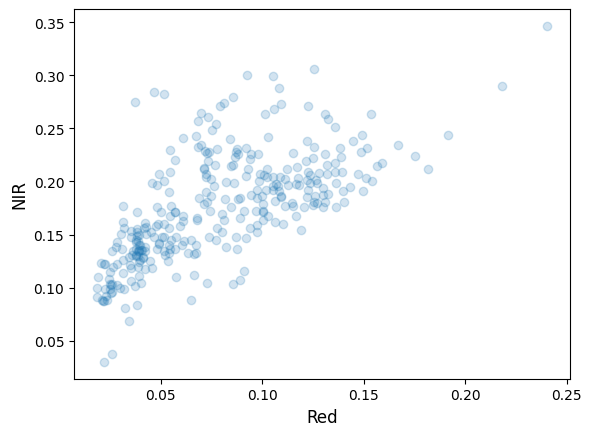

In [ ]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

# Saving images

Satellite images are extracted and downloaded as GeoTIFF files in the users' specified folder on Google Drive. The image collection chosen is from Google Earth Engine's Data Catalog (https://developers.google.com/earth-engine/datasets/catalog/).



In [ ]:

import subprocess
import pandas as pd
from dateutil.relativedelta import relativedelta
import time 
from neg_data import *  # import function to create csv file to be read

# Creates a rectangle from a center point based on x and y 
# extension distance and projection parameters.
def makeRectangle(point, x_radius, y_radius, proj):
  pointLatLon = ee.Geometry.Point(point)
  pointMeters = pointLatLon.transform(proj, 0.001)
  coords = pointMeters.coordinates()
  minX = ee.Number(coords.get(0)).subtract(x_radius)
  minY = ee.Number(coords.get(1)).subtract(y_radius)
  maxX = ee.Number(coords.get(0)).add(x_radius)
  maxY = ee.Number(coords.get(1)).add(y_radius)
  rect = ee.Geometry.Rectangle([minX, minY, maxX, maxY], proj, False)
  return rect

create_neg('fire_nrt_J1V-C2_337732.csv') # creates csv file used below
df = pd.read_csv('neg_data.csv')  # csv file of recorded fires, dates subtracted 3 mths


collection = ee.ImageCollection('MODIS/061/MOD09A1')


for i, row in df.iterrows():
  lat = row['latitude'] 
  long = row['longitude'] 
  acq_date_start = pd.to_datetime(row['acq_date'])
  acq_date_end = acq_date_start + relativedelta(months=3)  # find image before fire start date
  point = [long, lat]  
  x_radius = 0.9  # in degrees
  y_radius = 0.9
  proj = 'EPSG:4326'  # standard latitiude/longitude projection 

  rect = makeRectangle(point, x_radius, y_radius, proj)

  filter_collection = collection.filterBounds(rect).filterDate(acq_date_start, acq_date_end).sort('CLOUD_COVER').first()
  image_metadata = filter_collection.getInfo().get('features')
  idx = 0
  image = ee.Image(image_metadata[idx]['id'])  # take first image that matches rectangle bounds

  # Export image task
  task = ee.batch.Export.image.toDrive(**{
    'image': image, #.visualize(min= 0, max= 1, palette= ['green','red','blue']),
    'description': 'image' + str(i),
    'folder':'Example_folder',  # user specified folder
    'crs': 'ESPG:4326',
    'region': rect
})
  task.start()

import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id: BN6ONCA4IHFOSECP7RIW5LFC).
Polling for task (id

# Wildfire boundary tutorial
[How to generate wildfire boundary maps with Earth Engine](https://medium.com/google-earth/how-to-generate-wildfire-boundary-maps-with-earth-engine-b38eadc97a38#:~:text=Google%20Earth%20Engine%20provides%20out,libraries%20to%20visualize%20wildfire%20activity)



In [ ]:
# Image collections
#collection16 = ee.ImageCollection("NOAA/GOES/16/FDCF")
#collection17 = ee.ImageCollection("NOAA/GOES/17/FDCF")
#collection_modis = ee.ImageCollection(“MODIS/006/MOD14A1”

In [ ]:
# Time and location of the fire.
kincade = {
    "longitude": -122.8,
    "latitude": 38.7,
    "start": '2019-10-23',
    "end": '2019-11-06'}

# Region of interest.
radius_of_interest_meters = 40000;
area_of_interest = ee.Geometry.Point([kincade["longitude"], kincade["latitude"]]).buffer(radius_of_interest_meters)

# Satellite data.
goes_16_data = ee.ImageCollection('NOAA/GOES/16/FDCF')\
.filterDate(kincade["start"], kincade["end"])\
.filterBounds(area_of_interest)

goes_17_data = ee.ImageCollection('NOAA/GOES/17/FDCF')\
.filterDate(kincade["start"], kincade["end"])\
.filterBounds(area_of_interest)



NameError: ignored

In [ ]:
# Conversion from mask codes to confidence values.
fire_mask_codes = [10, 30, 11, 31, 12, 32, 13, 33, 14, 34, 15, 35]
confidence_values = [1.0, 1.0, 0.9, 0.9, 0.8, 0.8, 0.5, 0.5, 0.3, 0.3, 0.1, 0.1]
default_confidence_value = 0

def map_from_mask_codes_to_confidence_values(image): 
  return image \
  .clip(area_of_interest)\
  .remap(fire_mask_codes, confidence_values, default_confidence_value);

goes_16_confidence = goes_16_data\
.select(['Mask'])\
.map(map_from_mask_codes_to_confidence_values)

goes_17_confidence = goes_17_data\
.select(['Mask'])\
.map(map_from_mask_codes_to_confidence_values)

goes_16_max_confidence = goes_16_confidence\
.reduce(ee.Reducer.max())
goes_17_max_confidence = goes_17_confidence\
.reduce(ee.Reducer.max())

In [ ]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [ ]:


# Create a folium map object.
my_map = folium.Map(location=[kincade["latitude"], kincade["longitude"]], zoom_start=9)


In [ ]:
# creating a map
affected_area_palette = ['white', 'yellow', 'orange', 'red', 'purple']

##wrong code ## my_map.add_ee_layer(area_of_interest, {'color': 'green'}, 'Area of interest')#, true, 0.2);
#my_map.add_ee_layer(goes_16_max_confidence, {'opacity': 0.3, 'min': 0, 'max': 1, 'palette': affected_area_palette}, 'GOES 16 maximum confidence')
#my_map.add_ee_layer(goes_17_max_confidence, {'opacity': 0.3, 'min': 0, 'max': 1, 'palette': affected_area_palette}, 'GOES 17 maximum confidence')

combined_confidence = ee.ImageCollection([goes_16_max_confidence,
goes_17_max_confidence])\
.reduce(ee.Reducer.min());

#my_map.add_ee_layer(combined_confidence, {'opacity': 0.3, 'min': 0, 'max': 1, 'palette': affected_area_palette}, 'Combined confidence')



In [ ]:
# smoothing output
kernel = ee.Kernel.square(2000, 'meters', True)

smoothed_confidence = combined_confidence.reduceNeighborhood(reducer= ee.Reducer.mean(), kernel=kernel, optimization= 'boxcar')

#my_map.add_ee_layer(smoothed_confidence, {'opacity': 0.3, 'min': 0, 'max': 1, 'palette': affected_area_palette}, 'Smoothed confidence')

high_confidence = smoothed_confidence.gt(0.6)
my_map.add_ee_layer(high_confidence, {'opacity': 0.3, 'min': 0, 'max': 1, 'palette': affected_area_palette}, 'High confidence')


# reduce to a feature
affected_areas = high_confidence.reduceToVectors(scale= 200,  # 200 m/pixel 
                                                 maxPixels= 1e10,
                                                geometry= area_of_interest)\
                                                  .filter(ee.Filter.eq('label', 1))

affected_areas_outline = ee.Image().byte().paint(featureCollection= affected_areas, width= 2)
#my_map.add_ee_layer(affected_areas_outline, {'palette': 'purple'}, 'Affected areas')#, 'true', 0.3)

def smooth(feature):
  max_error_meters = 500
  return ee.Feature(feature).simplify(max_error_meters)

affected_areas_smoothed = ee.FeatureCollection(affected_areas).map(smooth)
affected_areas_smoothed_outline = ee.Image().byte().paint(featureCollection= affected_areas_smoothed, width= 2)

my_map.add_ee_layer(affected_areas_smoothed_outline, {'palette': 'purple'}, 'Smoothed affected areas')#, True, 0.3)

# Display the map.
display(my_map)
#geometry = affected_areas.geometry()


In [ ]:
#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

# Testing coordinates


In [ ]:
import pandas as pd

data = pd.read_csv('modis_2000_Canada.csv')
#create a map
this_map = folium.Map(prefer_canvas=True)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point['latitude'], point['longitude']],
                        radius=2,
                        weight=5).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
data.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())

#Save the map to an HTML file
this_map.save('simple_dot_plot.jpg')

this_map